In [1]:
# Lets import everything we need

import networkx as nx
import osmnx as ox
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np

# We are now also going to load the cured small graph which goes from the 
# National Museum of Mexican Art to the Millennium Park

G = ox.load_graphml(r'C:\Users\elchi\Desktop\UIC_Chicago\Knowledge_graph\Backend\Backtracking\chicago_medium.graphml')
print("Loaded graph")

# Add speeds/travel times
G = ox.routing.add_edge_speeds(G)
G = ox.routing.add_edge_travel_times(G)

# |-----------------------

# Now we load the rain data which we identified in the previous notebook
date = '20250706'
timezone = "t00z"
weather_data = rf'C:\Users\elchi\Desktop\UIC_Chicago\Knowledge_graph\Backend\try_clean\good_candidates\{date}\{timezone}\outputs\RAIN.nc'

# We only need to work with a subset of this data, so we will crop it to only be inside the 
# bounding of the city of Chicago
# The bounding box of Chicago is approximately:
lat_min, lat_max = 41.61, 42.04
lon_min, lon_max = -88.03, -87.30

# The netCDF file has 48 reading for each 12 hour period, we will use a specific time index
# This time index corresponds to 6 AM, since the reading started at midnight and each reading is 30 minutes apart
# The day of the reading is the 6th of July, 2025

time = 18

ds = nc.Dataset(weather_data)
rain = ds.variables['RAIN'][time, :, :] 
lats = ds.variables['XLAT'][time, :, :]
lons = ds.variables['XLONG'][time, :, :]

# Clip by bounding box
mask = (lats >= lat_min) & (lats <= lat_max) & (lons >= lon_min) & (lons <= lon_max)
rain_masked = np.where(mask, rain, np.nan)

print("Loaded weather data")




Loaded graph
Loaded weather data


In [2]:
# The idea behind this step is to navigate a weighted graph with data at time of query
# In this case we are simply minimizing rain exposure

# Since we need a weighted graph we will create two new edge attributes called "rain_length" and "rain_travel_time"
# This attribute will be the length of the edge multiplied by a penalty factor based on the rain

# Function to get rain at a point
def get_rain_at_point(lat, lon, rain_grid, lats, lons):
    i = np.argmin(np.abs(lats[:,0] - lat))
    j = np.argmin(np.abs(lons[0,:] - lon))
    return rain_grid[i,j]


for u, v, k, data in G.edges(keys=True, data=True):
    # compute midpoint of edge from node coordinates
    y1, x1 = G.nodes[u]['y'], G.nodes[u]['x']
    y2, x2 = G.nodes[v]['y'], G.nodes[v]['x']
    lat, lon = (y1 + y2)/2, (x1 + x2)/2

    rain_mm = get_rain_at_point(lat, lon, rain, lats, lons)
    penalty_factor = rain_mm / 10  # adjust sensitivity here
    data["rain_length"] = data.get("length", 1) * penalty_factor
    data["rain_travel_time"] = data.get("travel_time", 1) * penalty_factor    

In [3]:
# Now we pick an origin and destination, in this case we are going from the
# National Museum of Mexican Art to the Millennium Park

orig = ox.distance.nearest_nodes(G, Y=41.85597592142765, X=-87.6728179826436)
dest = ox.distance.nearest_nodes(G, Y=41.88385758119282, X=-87.62068882287)

# Now we can compute the shortest path based on rain_length and a shortest path based on travel_time for comparison

route = nx.shortest_path(G, source=orig, target=dest, weight="rain_length")
fast_route = nx.shortest_path(G, source=orig, target=dest, weight="travel_time")

# Then we could print stats about the two routes

route_length = int(sum(ox.routing.route_to_gdf(G, route, weight="length")["length"]))
route_time = int(sum(ox.routing.route_to_gdf(G, route, weight="travel_time")["travel_time"]))

fast_route_length = int(sum(ox.routing.route_to_gdf(G, fast_route, weight="length")["length"]))
fast_route_time = int(sum(ox.routing.route_to_gdf(G, fast_route, weight="travel_time")["travel_time"]))

print(f"Route minimizing rain exposure is {route_length} meters and takes {route_time} seconds")
print(f"Fastest route is {fast_route_length} meters and takes {fast_route_time} seconds")


Route minimizing rain exposure is 10220 meters and takes 916 seconds
Fastest route is 7533 meters and takes 531 seconds


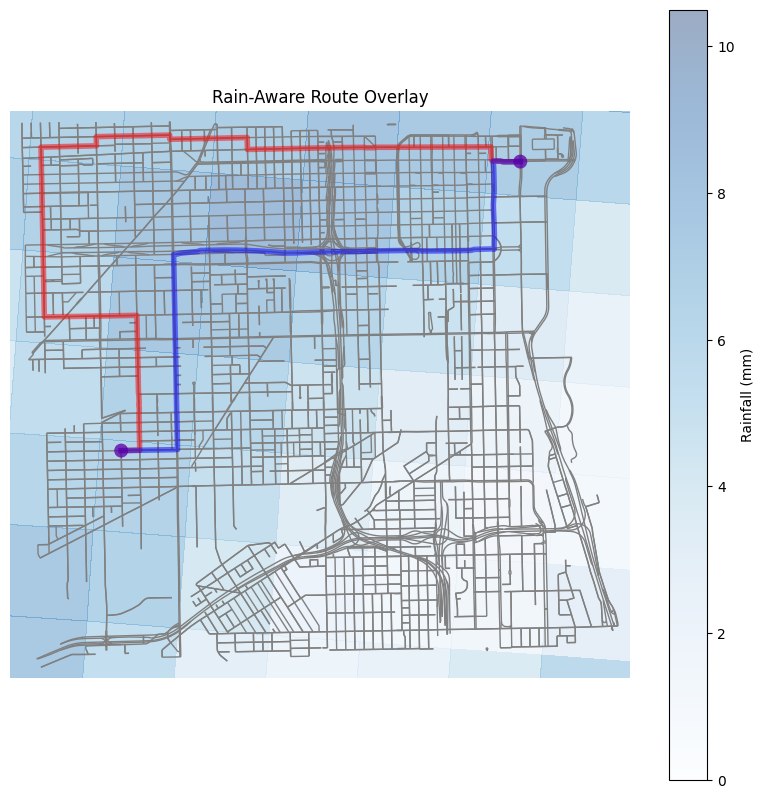

In [4]:
# Now we just plot everything

fig, ax = plt.subplots(figsize=(10, 10))

# Rainfall background
c = ax.pcolormesh(lons, lats, rain, cmap="Blues", shading="auto", alpha=0.4)
fig.colorbar(c, ax=ax, label="Rainfall (mm)")
c.set_clim(0, 10.5)

# Streets
ox.plot_graph(G, ax=ax, node_size=0, edge_color='gray', edge_linewidth=1, show=False, close=False)

# Rain-aware route
ox.plot_graph_routes(
    G,
    routes=[route, fast_route],
    route_colors=["red", "blue"],
    route_linewidth=3,
    node_size=0,
    ax=ax,
    show=False,
    close=False
)

plt.title("Rain-Aware Route Overlay")
plt.show()
